# Test of Movie Face Recognition System

We test our face recognition model for some random pictures of Pulp Fictions' scenes not used during the training of our model. 

In [30]:
import argparse
import time
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms
import torch
from torch import nn
import torchvision.models as models
from model import SiameseNetwork, TripletLoss
from utils import *

We create some dictionaries where we can find the path for the images which will be compared to our test images. And an other dictionary where the path for picture of actors.

In [31]:
pf_actor = {"Bruce Willis" : 'dataset/pf_actor/BW/',
            "John Travolta" : 'dataset/pf_actor/JT',
            "Samuel L. Jackson" : 'dataset/pf_actor/SLJ',
            "Uma Thurman" : 'dataset/pf_actor/UT'} 

In [32]:
actor_img = {"Bruce Willis" : 'dataset/actor_image/BW/Bruce_Willis.jpeg',
            "John Travolta" : 'dataset/actor_image/JT/John_Travolta.webp',
            "Samuel L. Jackson" : 'dataset/actor_image/SLJ/Samuel_L_Jackson.webp',
            "Uma Thurman" : 'dataset/actor_image/UT/Uma_Thurman.jpeg'} 

## Image Process Setup

We set up our image transformation procedure.

In [34]:
transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

In [35]:
def get_embedding(image, model):
    """
    This function returns the embedding of the image
    """
    with torch.no_grad():
        embedding = model.forward_one(image.unsqueeze(0))
    return embedding

#### Models' Setup

In [36]:
model_yolo = YOLO('../Face_detection/yolov8n-face.pt')

In [37]:
def load_pretrained_model(input_shape):
    """
    This function load resnet50 CNN pretrained model and replace the mlp by our custom mlp
    """
    pretrained_model = models.resnet50(pretrained=True)

    
    for param in list(pretrained_model.parameters())[:-27]:
        param.requires_grad = False

    
    features_dim = pretrained_model.fc.in_features
    pretrained_model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(features_dim, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, 256),
        nn.ReLU(),
        L2Normalize()
    )
    
    return pretrained_model

class L2Normalize(nn.Module):
    def forward(self, x):
        return nn.functional.normalize(x, p=2, dim=1)

In [38]:

class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super(SiameseNetwork, self).__init__()
        self.encoder = encoder
        self.distance_layer = DistanceLayer()

    def forward(self, anchor, positive, negative):
        encoded_a = self.encoder(anchor)
        encoded_p = self.encoder(positive)
        encoded_n = self.encoder(negative)
        ap_distance, an_distance = self.distance_layer(encoded_a, encoded_p, encoded_n)
        return ap_distance, an_distance

class SiameseModel(nn.Module):
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin

    def forward(self, anchor, positive, negative):
        ap_distance, an_distance = self.siamese_network(anchor, positive, negative)
        return ap_distance, an_distance
    

class DistanceLayer(nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

    def forward(self, anchor, positive, negative):
        ap_distance = torch.sum((anchor - positive) ** 2, dim=-1)
        an_distance = torch.sum((anchor - negative) ** 2, dim=-1)
        return ap_distance, an_distance

In [39]:
encoder = load_pretrained_model(input_shape=(3, 128, 128))
siamese_network = SiameseNetwork(encoder)

/Users/alexisrevelle/miniconda3/envs/data-science/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexisrevelle/miniconda3/envs/data-science/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
model_recognition = SiameseModel(siamese_network)
model_recognition.load_state_dict(torch.load("siamese_model-final"))  # Replace 'siamese_model.pth' with the actual model file path
model_recognition.eval()  

SiameseModel(
  (siamese_network): SiameseNetwork(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [41]:
def get_embedding(image, siamese_model):
    with torch.no_grad():
        embedding = siamese_model.siamese_network.encoder(image.unsqueeze(0))
    return embedding


In [42]:
def model_inference(cropped_embed):
    """
    This function takes the embedding of the face detected on the image
    and returns our prediction.
    """
    dist_actor = {actor : [] for actor in pf_actor.keys()}
    for actor in pf_actor.keys():
        for file in os.listdir(pf_actor[actor]):
            if file.endswith('pgm'):
                file_path = os.path.join(pf_actor[actor], file)
                img_input = transform(cv2.imread(file_path))


                img_emb = get_embedding(img_input, model_recognition)
                distance = torch.norm(cropped_embed - img_emb) 
                dist_actor[actor].append(distance.item())
    
    distance = {actor: np.mean(values) for actor, values in dist_actor.items()}
    pred = min(distance, key=lambda k: distance[k])
    return pred

In [43]:
def Test_model(image_path):
    results = model_yolo(image_path, save = True)

    original_image = Image.open(image_path)

    xyxy_tensor = results[0].boxes.xyxy
    xyxy_list = xyxy_tensor.numpy().astype(int)

    for coord in xyxy_list:
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        coord_tuple = tuple(coord)
        cropped_image = original_image.crop(coord_tuple)
        cropped_input = cv2.cvtColor(np.array(cropped_image), cv2.COLOR_BGR2GRAY)
        cv2.imwrite('cropped.pgm', cropped_input)
        cropped_input_gray = cv2.imread('cropped.pgm')
        cropped_input = transform(cropped_input_gray)
        cropped_embed = get_embedding(cropped_input, model_recognition)

        pred = model_inference(cropped_embed)
        axs[0].imshow(original_image)
        axs[0].axis('off')
        axs[0].set_title('original_image')

        axs[1].imshow(cropped_image)
        axs[1].axis('off')
        axs[1].set_title('Detected Face')

        axs[2].imshow(Image.open(actor_img[pred]))
        axs[2].axis('off')
        axs[2].set_title('Actor Predicted : {}'.format(pred))

    plt.show()  

# Test First Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_1.jpeg: 448x640 2 faces, 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict25


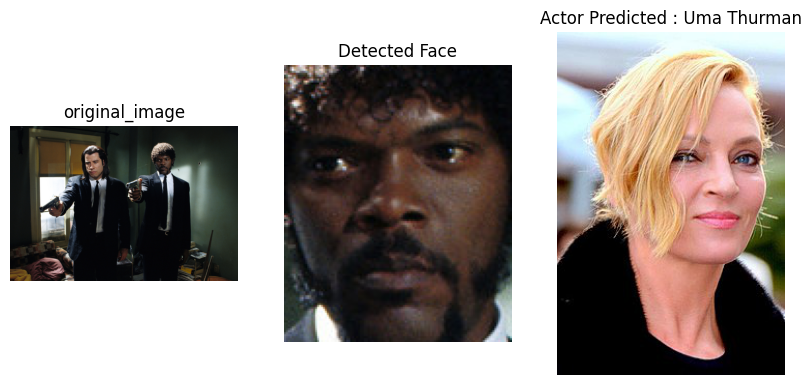

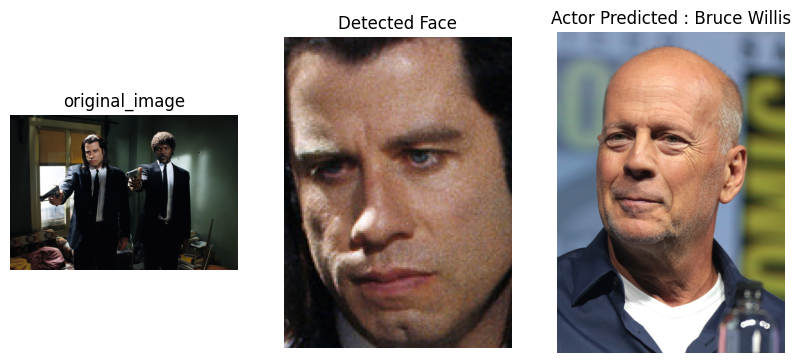

In [52]:
image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_1.jpeg' 

Test_model(image_path)

## Test Second Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_2.webp: 384x640 2 faces, 56.8ms
Speed: 4.2ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict25


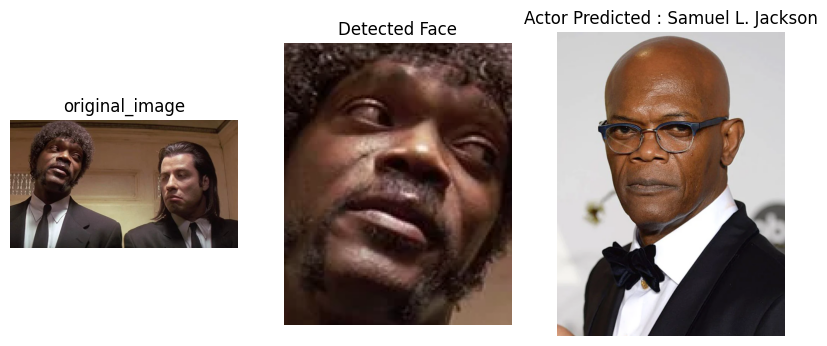

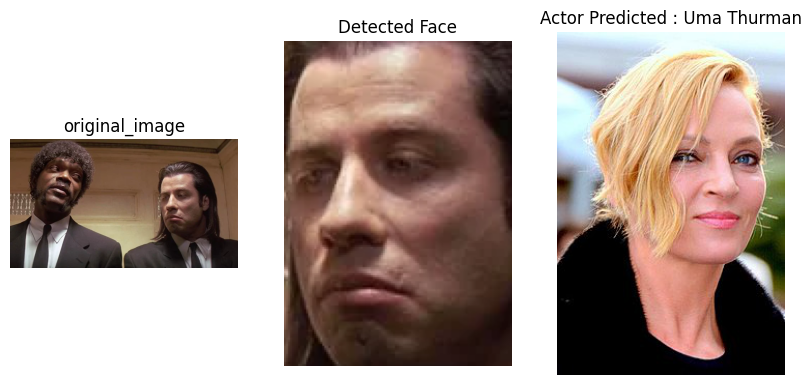

In [46]:
image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_2.webp' 

Test_model(image_path)

## Test Third Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_3.jpeg: 384x640 2 faces, 46.4ms
Speed: 1.2ms preprocess, 46.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict25


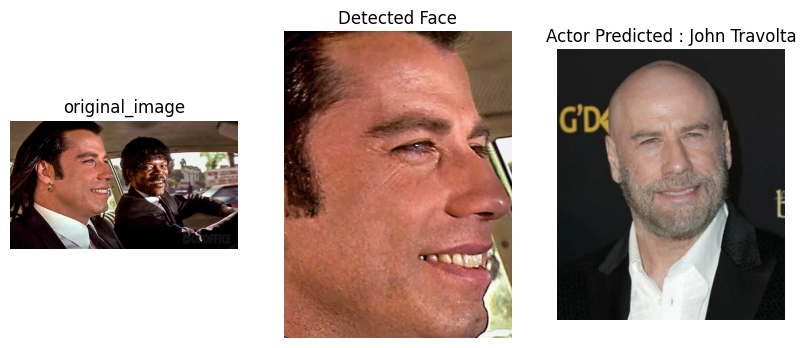

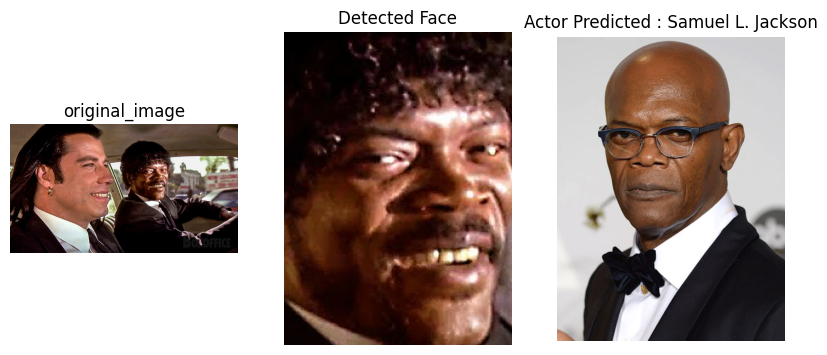

In [47]:
image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_3.jpeg' 

Test_model(image_path)

## Test Fourth Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_4.webp: 352x640 1 face, 46.0ms
Speed: 1.6ms preprocess, 46.0ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict25


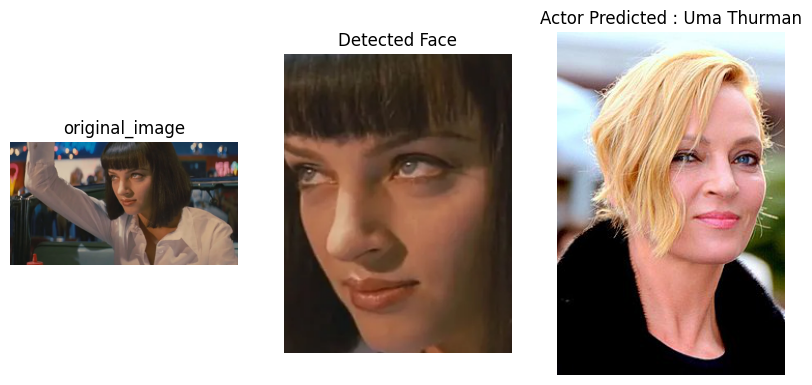

In [48]:
image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_4.webp' 

Test_model(image_path)

## Test Fifth Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_5.jpeg: 288x640 1 face, 46.4ms
Speed: 1.2ms preprocess, 46.4ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict25


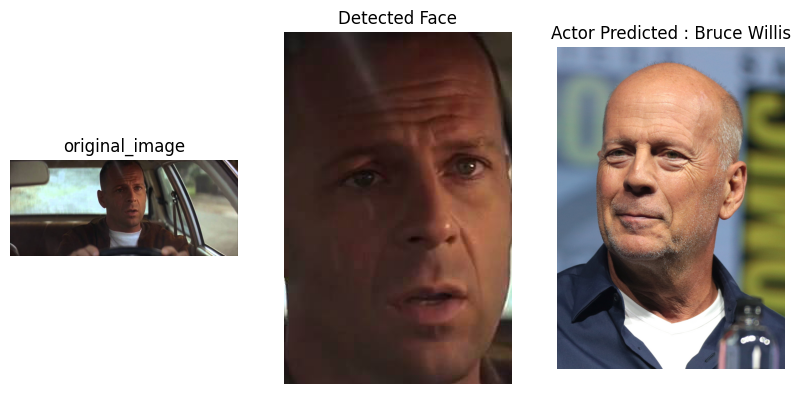

In [49]:
# load image

image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_5.jpeg' 
Test_model(image_path)


## Test Sixth Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_6.jpeg: 384x640 1 face, 48.3ms
Speed: 2.0ms preprocess, 48.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict25


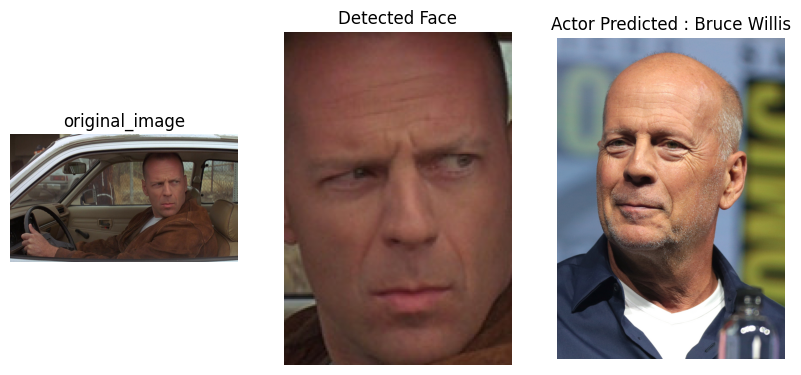

In [50]:
image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_6.jpeg' 
Test_model(image_path)

## Test Seventh Image


image 1/1 /Users/alexisrevelle/Documents/MFRS_ENSAE/Face_recognition/Olivetti_dataset/faces/pf_scene_test/pf_test_9.jpeg: 384x640 1 face, 73.7ms
Speed: 2.2ms preprocess, 73.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict25


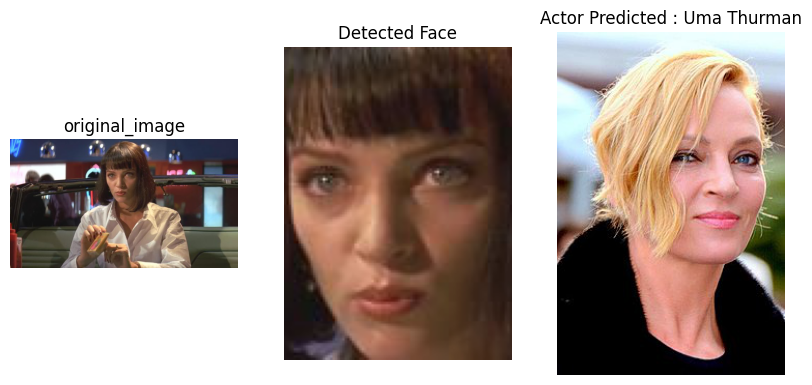

In [51]:
image_path = 'Olivetti_dataset/faces/pf_scene_test/pf_test_9.jpeg' 
Test_model(image_path)